# 3190044 IOANNIS GKIONIS

## Disruptive science assignment - Applied Machine Learning (2022-2023)

### Preprocessing

First off we import all the libraries we will be using in this assignment.

In [1]:
import sqlite3
import pandas as pd
import datetime
import re
import numpy as np
import statsmodels.formula.api as snf
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

After that, we connect to the database. Note that all the tables of the database have been altered with indices on all keys/primary keys, unique ones wherever possible. This slightly increases the disk size of the .db file but results in much faster query execution, which ends up being very useful in this particular assignment.

The indices used are declared below and all SQL used here is in the indices.sql file on the same folder as this notebook

- CREATE UNIQUE INDEX "idx_cdindex" ON cdindex.doi

- CREATE UNIQUE INDEX "idx_work_auth" ON work_authors.id

- CREATE INDEX "idx_work_auth_workid" ON work_authors.work_id

- CREATE INDEX "idx_work_ref" ON work_references.work_id

- CREATE INDEX "idx_work_sub" ON work_subjects.work_id

- CREATE UNIQUE INDEX "idx_works" ON works.id

- CREATE UNIQUE INDEX "idx_works_doi" ON works.doi

By running the indices.sql file or running each line seperately through DB Browser we can generate these indices (note that the ones on works take a bit longer to execute than the rest)

In [2]:
con = sqlite3.connect("publications_graph.db")

We then run this SQL query that returns all useful columns from the database. The query is also included in the query.sql file and can be ran through software such as DB Browser

Note: I noticed that adding and removing the month and day columns does not significantly affect the result of the models, so i decided to simplify the SQL query by removing those (i had to use stuff like julianday("now") - julianday(work_references.year || '-01-01') to generate the mean and variance of the crossreferenced works' age) and only keeping the year column, which ended up making the models much faster without losing much valuable information

In [3]:
query = '''SELECT works.doi AS doi, works.abstract AS abstract, works.published_year AS year, works.title AS title,
GROUP_CONCAT(work_subjects.name, '|') AS subjects,
GROUP_CONCAT(work_references.doi, '|') AS crossrefs,

AVG(2023 - work_references.year) AS crossref_mean_age,

AVG((2023 - work_references.year) * ( 2023 - work_references.year)) - (AVG(2023 - work_references.year) *
AVG(2023 - work_references.year)) AS crossref_var_age,

cdindex.cdindex AS cdindex

FROM works
JOIN work_subjects ON works.id == work_subjects.work_id
JOIN work_authors ON works.id == work_authors.work_id
JOIN work_references ON works.id == work_references.work_id
JOIN cdindex ON works.doi == cdindex.doi

WHERE cdindex.cdindex IS NOT NULL AND works.published_year IS NOT NULL AND work_references.year IS NOT NULL GROUP BY works.doi'''

worksdf = pd.read_sql_query(query, con)

con.close()

### Model 1: OLS

We then create the first model. I chose an ordinary least squares regression model from the statsmodels.formula.api library similar to the one we used in the previous assignment. We use the mean and variance of the age of each crossreference as well as the year the paper was released as the independent variables and the cdindex as the dependent one.

In [4]:
columns = "cdindex ~ crossref_mean_age + crossref_var_age + year"
model = snf.ols(columns, data = worksdf)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cdindex   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     477.5
Date:                Tue, 28 Feb 2023   Prob (F-statistic):          1.33e-305
Time:                        18:51:35   Log-Likelihood:                 27293.
No. Observations:               46159   AIC:                        -5.458e+04
Df Residuals:                   46155   BIC:                        -5.454e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.8703      0.128     37.974      0.000       4.619       5.122
crossref_mean_age  4.687e-08   7.53e-07      0.062      0.950   -1.43e-06    1.52e-06
crossref_var_age   2.495e-15   4.44e-14      0.056      0.955   -8.46e-14    8.95e-14
year                 -0.0024   6.37e-05    -37.848      0.000      -0.003      -0.002
==============================================================================
Omnibus:                    50058.422   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3488561.217
Skew:                           5.661   Prob(JB):                         0.00
Kurtosis:                      44.057   Cond. No.                     5.77e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.77e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note: before we even generate predictions we can clearly see the negative coefficient on the year column so we can tell that the cdindex decreases as the value of the year column increases, which affirms our assumption that papers recently have become less and less disruptive/innovative


We then generate a dataframe of predictions from that model and group them by year (since we want to track how the cdindex changes with time)

In [5]:
predictions = res.get_prediction(worksdf)
preddf = predictions.summary_frame(alpha=0.05) #95% C.I.
preddf['year'] = worksdf.year
preddf = preddf.groupby(by="year").mean()

And finally, we plot the results using matplotlib

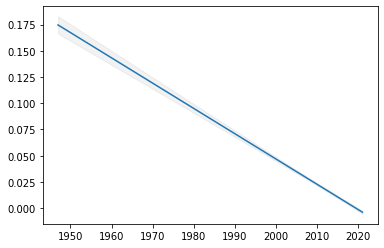

In [6]:
ax = plt.axes()
ax.plot(preddf.index, preddf['mean'])
ax.fill_between(preddf.index, preddf['mean_ci_lower'], preddf['mean_ci_upper'], alpha=.1, color='grey')

We can clearly see a line with a downward slope indicating that the cdindex of recent papers has been consistently decreasing. What is interesting is that on top of that, the high and low values of the 95% confidence interval are much closer to the mean value as years go by, meaning there's less variance in the value of cdindex in more recent papers compared to older ones

### Model 2: Neural Network

First off we copy the dataframe we used in the last model, pop the cdindex column in order to make a y vector and drop a few columns we will not be using

In [7]:
X = worksdf.copy()
X = X.drop(columns = ['crossrefs', 'doi', 'subjects'])
y = X.pop('cdindex')
y = y.to_numpy()

Then we define a function that takes a string and converts it to lowercase, removes punctuation, empty spaces, special characters and removes a few words that appear in the abstract almost always and apply that function to every string dtype column of the X dataframe

In [8]:
def standardize_text(x):
    redundantwords = ['jats', 'title', 'abstract', '\n']
    lower = x.lower()
    no_num = re.sub(r'\d+','',lower)
    no_punc = re.sub(r'[^\w\s]','', no_num)
    no_wspace = no_punc.strip()
    for word in redundantwords:
        no_wspace = no_wspace.replace(word, '');
    return no_wspace

X['abstract'] = X['abstract'].apply(lambda x: standardize_text(x))
X['title'] = X['title'].apply(lambda x: standardize_text(x))
# X['subjects'] = X['subjects'].apply(lambda x: standardize_text(x))

We then use sklearn's train_test_split function to generate train and test data, then standardize all the numerical values of both the train and test set, and finally create seperate dataframes with all the numerical value columns

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

sc = StandardScaler()
X_train[['year', 'crossref_mean_age', 'crossref_var_age']] = sc.fit_transform(X_train[['year', 'crossref_mean_age', 'crossref_var_age']])
X_test[['year', 'crossref_mean_age', 'crossref_var_age']] = sc.fit_transform(X_test[['year', 'crossref_mean_age', 'crossref_var_age']])

X_train_num = X_train[['year', 'crossref_mean_age', 'crossref_var_age']]
X_test_num = X_test[['year', 'crossref_mean_age', 'crossref_var_age']]

We create an embedding layer using a pretrained model for text embeddings and then create the 3 models we will be using. We implement early stopping at 7 epochs of no improvement in validation loss.

The first model takes the 3 numerical columns and runs them through a relatively small neural network of 2 hidden layers with 25% dropout between the first and second hidden layer.

The second and third model take the abstract and title of the papers respectively and run them through a bigger network with more hidden layers and more neurons in said layers (the one for abstracts is bigger than the one for titles because the length of abstracts is way bigger than that of titles)

In [10]:
EMBEDDING_URL = "https://tfhub.dev/google/nnlm-en-dim50/2"
embedding_layer = hub.KerasLayer(EMBEDDING_URL, input_shape=[], dtype=tf.string, trainable=False)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model1 = Sequential([
          Input(shape=3),
          Dense(units=128, activation="relu"),
          Dropout(0.25),
          Dense(units=64, activation="relu"),
          Dense(units=1, activation="linear"),
      ])

model2 = Sequential([
          embedding_layer,
          Dense(units=512, activation="relu"),
          Dropout(0.25),
          Dense(units=1024, activation="relu"),
          Dropout(0.35),
          Dense(units=512, activation="relu"),
          Dropout(0.25),
          Dense(units=256, activation="relu"),
          Dense(units=1, activation="linear"),
      ])

model3 = Sequential([
          embedding_layer,
          Dense(units=128, activation="relu"),
          Dropout(0.25),
          Dense(units=256, activation="relu"),
          Dropout(0.35),
          Dense(units=128, activation="relu"),
          Dropout(0.25),
          Dense(units=64, activation="relu"),
          Dense(units=1, activation="linear"),
      ])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


We then compile and fit the models on the training dataset using 10% of it as the validation set

In [11]:
model1.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())
history1 = model1.fit(x=X_train_num, y=y_train, batch_size=256, epochs=30, callbacks=[callback], validation_split=0.1, verbose=0)

model2.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())
history2 = model2.fit(x=X_train['abstract'], y=y_train, batch_size=256, epochs=30, callbacks=[callback], validation_split=0.1, verbose=0)

model3.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())
history3 = model3.fit(x=X_train['title'], y=y_train, batch_size=256, epochs=30, callbacks=[callback], validation_split=0.1, verbose=0)

Finally we define a simple function that plots the training loss and validation loss of the 3 models and run it once for each one and then evaluate the 3 models by calculating the test loss

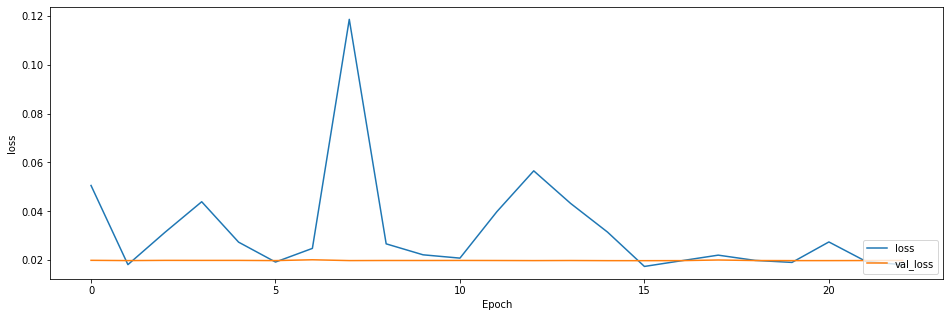

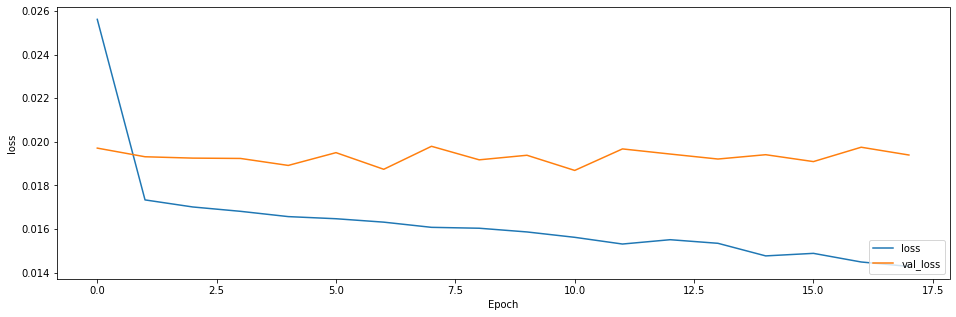

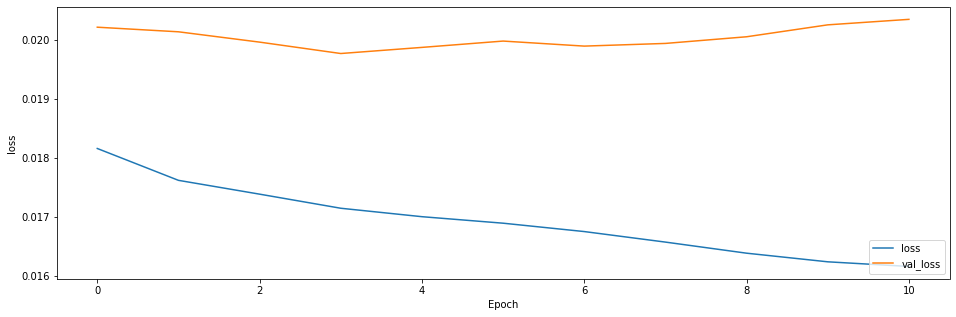

In [12]:
def history_plotter(history):
    plt.figure(figsize=(16, 5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')

history_plotter(history1)
history_plotter(history2)
history_plotter(history3)

In [13]:
model1.evaluate(x=X_test_num, y=y_test, batch_size=1, verbose=1)
model2.evaluate(x=X_test['abstract'], y=y_test, batch_size=1, verbose=1)
model3.evaluate(x=X_test['title'], y=y_test, batch_size=1, verbose=1)

9232/9232 [==============================] - 10s 1ms/step - loss: 0.0189


0.01887030526995659

We can see that by running the notebook over and over again, the only model that actually seems to train and have its loss value lessen as epochs go by is the second one, and even then not so consistently, leading us to assume that the words used in the abstract have some sort of correlation with how well the paper ranks on the cdindex metric.

Playing around with hyperparameters such as learning rate, optimizer, batch size, epochs, early stopping patience, # of layers, # of neurons per layer, dropout %, hidden layer activation functions etc. does not seem to change this by much.

By applying further NLP methods (better string manipulation, Word2Vec etc) or by experimenting with RNNs/LSTM etc. we might see some improvement to the second model and may actually see relevant results